In [ ]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [ ]:
df = pd.read_csv('Audi_combined_data.csv')

In [ ]:
df7 = df.copy()

In [ ]:
## Basic description of df7
df7.describe()

In [ ]:
## Looking at the nulls
df7.isna().sum()

In [ ]:
## Removing the ULEZ column, as it is entirely filled with nulls
df7.drop(columns='ULEZ', inplace=True)

## Dropping nulls in year, fuel, mileage, body, and transmission
df7.dropna(subset=['year', 'fuel', 'mileage', 'body', 'transmission'], inplace=True)

## Formatting rows
df7["price"] = df7["price"].replace('[£,]', '', regex=True).astype(float) ## [£,] is needed to deal with elements such as £6,600
df7['year'] = df7['year'].str.replace('\s\(.*\)$', '' , regex=True).astype(int)
df7.shape[1]

12

In [ ]:
df7['owners'].fillna(value=1, inplace=True)
df7['owners'] = df7['owners'].astype(int) ## converting owners to integer
# engine:
mode_engine = df7.groupby('filename')['engine'].agg(pd.Series.mode).reset_index()
mode_engine.rename(columns={'engine': 'Imp_engine'}, inplace=True)
df7 = df7.merge(mode_engine, how='left', left_on=['filename'], right_on=['filename'])
df7['engine'] = df7['engine'].fillna(df7['Imp_engine'])
df7.drop(columns='Imp_engine', inplace=True)
df7.drop( df7[df7['filename'] == './Datasets\Audi_E-Tron.txt'].index, inplace=True) ## Removing the rows with Audi E-Tron, as they do not have a mode for engine
#print(df7['engine'].value_counts())
# BHP:
mode_engine = df7.groupby('filename')['BHP'].agg(pd.Series.mode).reset_index()
mode_engine.rename(columns={'BHP': 'Imp_BHP'}, inplace=True)
df7 = df7.merge(mode_engine, how='left', left_on=['filename'], right_on=['filename'])
df7['BHP'] = df7['BHP'].fillna(df7['Imp_BHP'])
df7.drop(columns='Imp_BHP', inplace=True)

## Formatting engine
df7['engine'] = df7["engine"].str.replace('L', '', regex=True)#
df7['engine'] = df7['engine'].astype(float)

## New rows
df7['log_mileage'] = np.log(df7['mileage'])
df7['log_owners'] = np.log(df7['owners'])




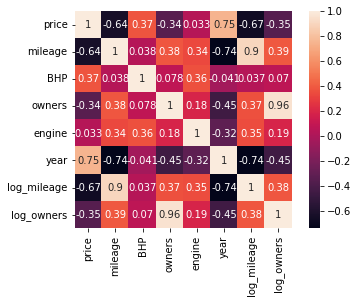

In [ ]:
df8= df7.copy()
## Heatmap for all columns

sns.heatmap(data=df8.corr(),
            annot = True,
            square = True
            )
plt.show()

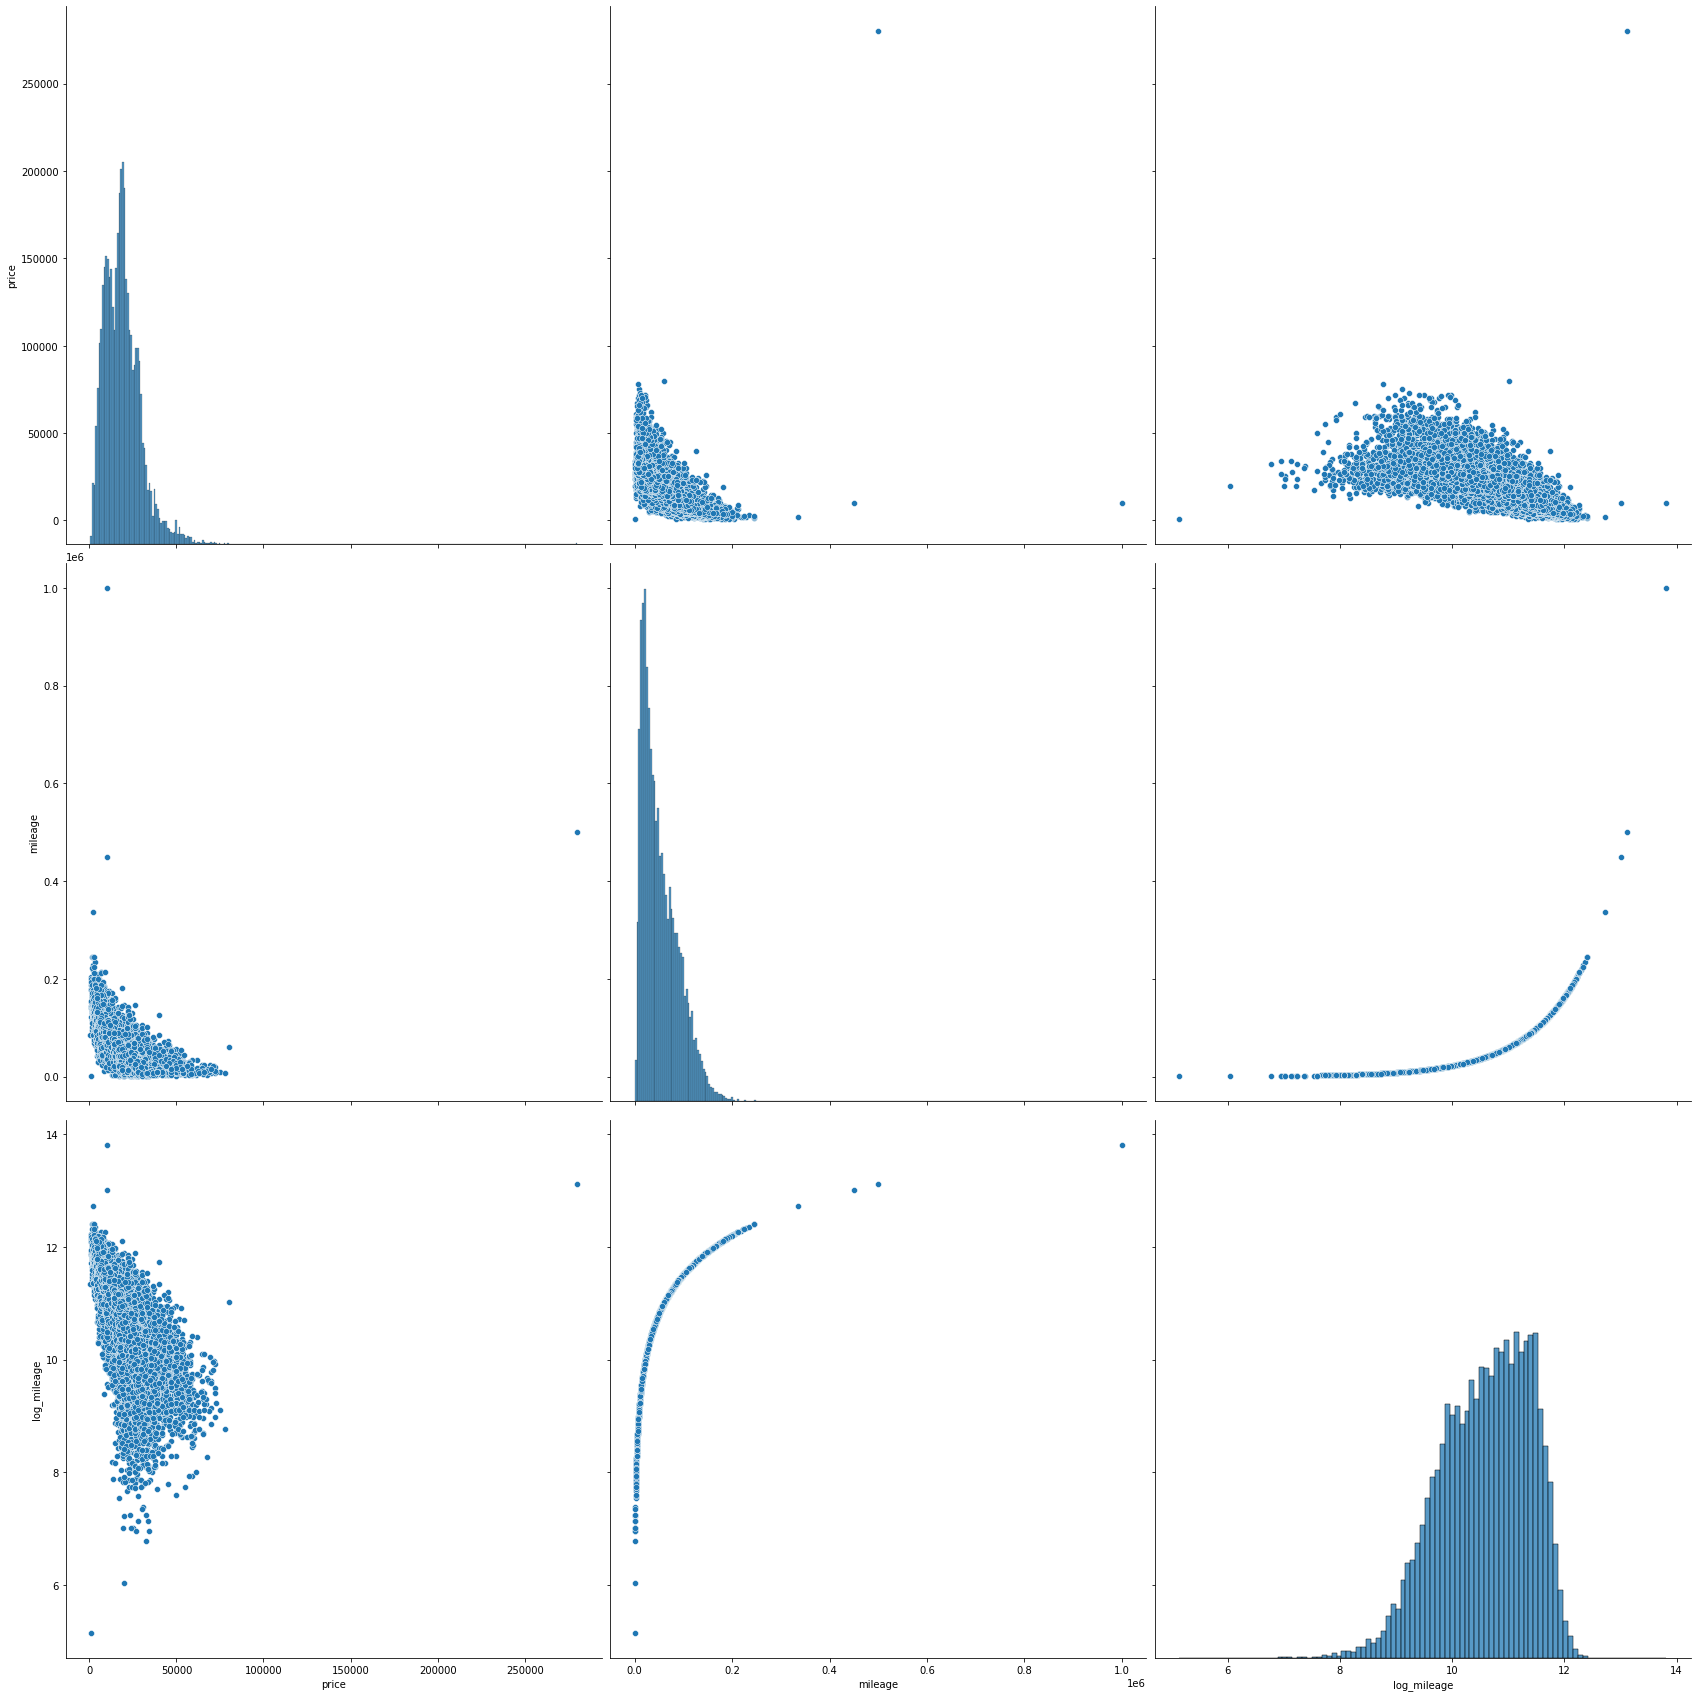

In [ ]:
## To check outliers##
sns.pairplot(df8[['price', 'mileage', 'log_mileage']], height=8)#.fig.set_size_inches(15,15)
#plt.figure(figsize=(10,10))
plt.show()

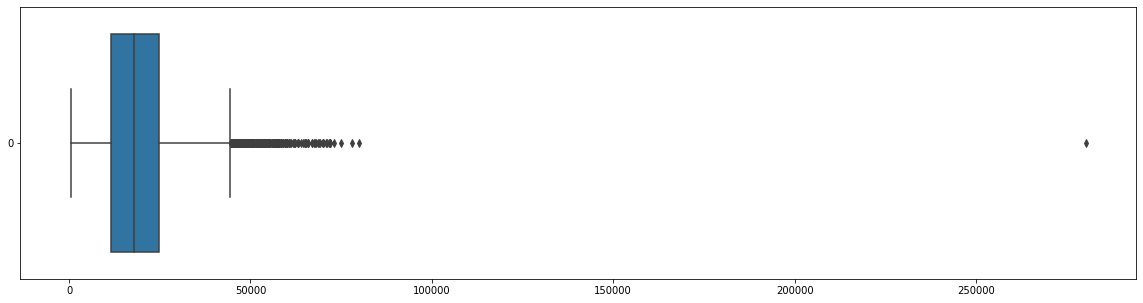

In [ ]:
plt.figure(figsize = (20, 5))
                
sns.boxplot(data = df8['price'],
            orient = 'h')
plt.show()

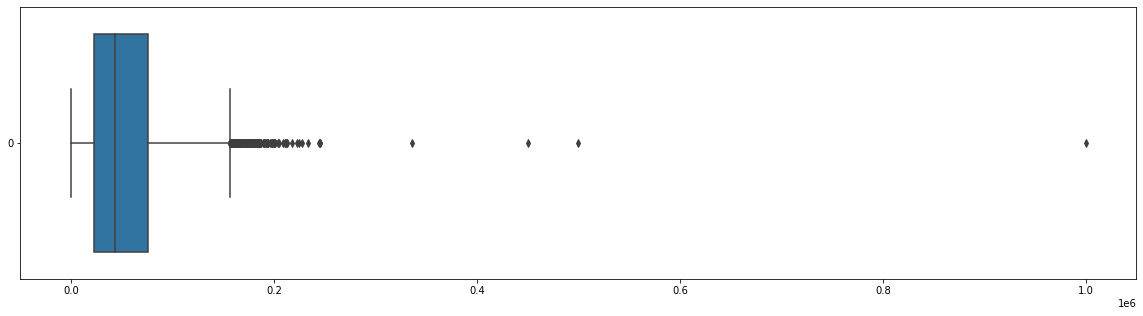

In [ ]:
plt.figure(figsize = (20, 5))
                
sns.boxplot(data = df8['mileage'],
            orient = 'h')
plt.show()

In [ ]:
sns.pairplot(df8[['price', 'owners']], height=8)  #.fig.set_size_inches(15,15)
#plt.figure(figsize=(35,35))
plt.show()

In [ ]:

fig = df8.iplot(kind='scatter',x='price',y='year',mode='markers',size=5)

In [ ]:
fig


In [ ]:
df8.iplot(kind='scatter',x='price',y='year',mode='markers',size=10)

In [ ]:


## One-hot encoding
# Transmission
#df7 = pd.get_dummies(df7, columns = ['transmission'], drop_first = False, prefix = 'gear_type')
# fuel
#df7 = pd.get_dummies(df7, columns = ['fuel'], drop_first = False, prefix = 'fuel_type')
# body
#df7 = pd.get_dummies(df7, columns = ['body'], drop_first = False, prefix = 'body_type')

## Counting nulls
df7.isna().sum()


In [ ]:
df7.dtypes

In [ ]:
## Test/Train split

X = df7.drop(columns=['name','link', 'price', 'filename'])
X = sm.add_constant(X)
y = df7['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [ ]:
print(f'The length of X is {len(X)}')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X_train.columns ## Columns for X_train

In [ ]:
## "Lisa's code"
## Code from stat.statexchange.com
def calculate_vif(X, thresh = 5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif)) # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables]) # finally, we print the variables that are still in our set
    return X.iloc[:, variables] # and return our X cut down to the remaining variables

In [ ]:
calculate_vif(X_train, 5.0) ## Only works if I drop engine

In [ ]:
## Feature cols from VIF. Don't forget that I need to add back in the constant column
vif_feature_cols = ['const', 'mileage', 'log_owners', 'gear_type_Manual', 'fuel_type_Diesel Plug-in Hybrid', 'fuel_type_Electric', 'fuel_type_Petrol', 'fuel_type_Petrol Hybrid', 'fuel_type_Petrol Plug-in Hybrid', 'body_type_Coupe', 'body_type_Estate', 'body_type_Hatchback', 'body_type_SUV', 'body_type_Saloon']

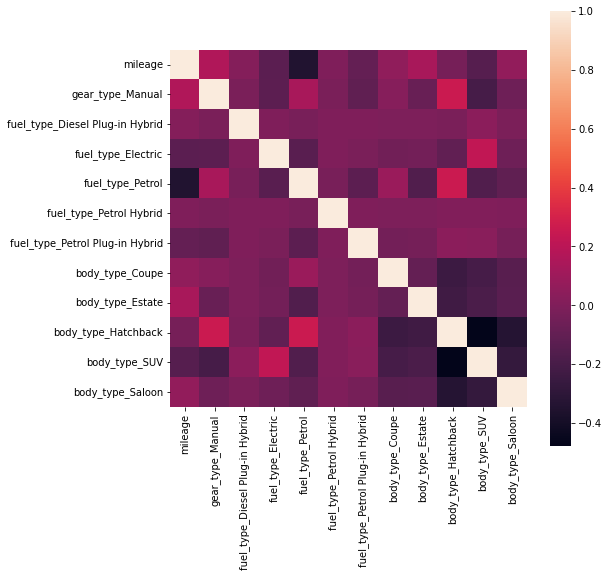

In [ ]:
## Removed constant and logmileage ##
selectedcol= X_train[[ 'mileage',  'gear_type_Manual', 'fuel_type_Diesel Plug-in Hybrid', 'fuel_type_Electric', 'fuel_type_Petrol', 'fuel_type_Petrol Hybrid', 'fuel_type_Petrol Plug-in Hybrid', 'body_type_Coupe', 'body_type_Estate', 'body_type_Hatchback', 'body_type_SUV', 'body_type_Saloon']]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(data=selectedcol.corr(),
            annot = False,
            square = True
            )
plt.show()

In [ ]:
## Linear regression test on training set with VIF feature columns

lin_reg = sm.OLS(y_train, X_train[vif_feature_cols])
results = lin_reg.fit()
results.summary()

## Adj R^2 is 0.713